In [1]:
%reload_ext autoreload
%autoreload 1
%matplotlib notebook

In [2]:
import os
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
import cv2
import numpy as np
from stl.mesh import Mesh
import pymesh
%aimport dsu

In [3]:
STL_PATH = '/home/burakov/prog/tra/resources/parts/front_left_node_1/model.stl'
PRED_PATH = '/home/burakov/prog/depth/bts/result_bts_tra_2/'
GT_PATH = '/home/burakov/Alpha/Data/Arrival/CORNER_NODE_LH_1000093_E_CORNER_NODE_RH_1000094_D_on_agv_000500/'

In [4]:
pred_it = dsu.iterate_ds(PRED_PATH, GT_PATH)

In [5]:
img_src, depth_pred, depth_gt, depth_gt_src, cam, pose_gt = next(pred_it)
cam_int, cam_p, cam_rot = cam

In [6]:
print('Img', img_src.shape)
print('Depth', depth_pred.shape, depth_gt.shape, depth_gt_src.shape)
print('Cam transform', cam)
print('Pose GT', pose_gt)

Img (2048, 3072, 3)
Depth (1024, 1536) (1024, 1536) (2048, 3072)
Cam transform ({'w': 3072, 'h': 2048, 'fx': 1556.5172862837085, 'fy': 1556.5172862837085, 'cx': 1536.0, 'cy': 1024.0, 'distortion': [0, 0, 0, 0, 0]}, array([1.94555955, 3.03476366, 1.4537583 ]), array([[-0.74821669,  0.47920431, -0.45884094],
       [ 0.6632276 ,  0.55832545, -0.49839928],
       [ 0.01734749, -0.67722664, -0.73556995]]))
Pose GT [(array([0.48737907, 2.08552338, 0.28180223]), array([-1.26788050e-01, -6.99212658e-04, -5.63081680e-03,  9.91913617e-01]), array([[-9.67848604e-01,  2.51533454e-01,  4.07234485e-05],
       [-2.51517705e-01, -9.67786169e-01, -1.13478710e-02],
       [-2.81495760e-03, -1.09932638e-02,  9.99935610e-01]])), (array([1.10737381, 2.24428909, 0.28180223]), array([-9.92659926e-01,  1.44019607e-03, -1.87539001e-04, -1.20930240e-01]), array([[ 9.70751683e-01, -2.40085755e-01,  2.39983920e-05],
       [ 2.40084674e-01,  9.70747605e-01,  2.90460822e-03],
       [-7.20651439e-04, -2.81389168

In [7]:
print(depth_pred.min(), depth_pred.mean(), depth_pred.max())
print(depth_gt.min(), depth_gt.mean(), depth_gt.max())

0.429 2.0631573 6.959
0.432 2.060631 5.865


<IPython.core.display.Javascript object>


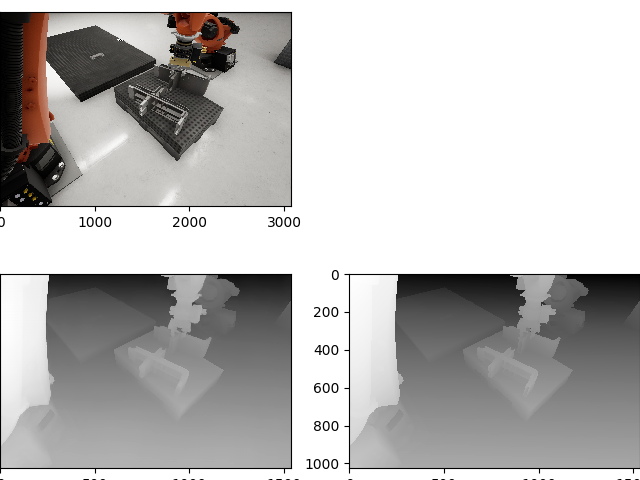

In [8]:
fig = plt.figure()
fig.subplots_adjust(left=0, top=1, right=1, bottom=0)
fig.add_subplot(2, 2, 1)
plt.imshow(img_src)
fig.add_subplot(2, 2, 3)
plt.imshow(np.log(depth_pred), cmap='Greys')
fig.add_subplot(2, 2, 4)
plt.imshow(np.log(depth_gt), cmap='Greys')

In [9]:
depth = depth_pred
# depth = depth_gt
# depth = depth_gt_src

scene_pcn = dsu.calc_pcn_from_depth(depth, cam_int, cam_p, cam_rot)
scene_pcn = np.ndarray.astype(scene_pcn, np.float32)

# viewpoint = cam_p
# _, scene_pcn = cv2.ppf_match_3d.computeNormalsPC3d(scene_pc, 10, False, viewpoint)

In [10]:
def get_limits(pc):
    p_mid = pc.mean(axis=0)
    sz = pc.max(axis=0) - pc.min(axis=0)
    radius = sz.max() / 2
    res = tuple((p_mid[i] - radius, p_mid[i] + radius) for i in range(3))
    return res

def visualize_pcn(pcn, show_normals=True, step1=5, step2=4, norm_len=.1):
    fig = plt.figure()
    fig.subplots_adjust(left=0, top=1, right=1, bottom=0)
    ax = fig.add_subplot(111, projection='3d')

    if len(pcn.shape) == 2:
        pcn = pcn[::step1, :]
        pcn1 = pcn
    else:
        pcn = pcn[::step1, ::step1, :]
        pcn1 = np.reshape(pcn, (-1, 6))
    ax.scatter(pcn1[:, 0], pcn1[:, 1], pcn1[:, 2], s=1)

    if show_normals:
        if len(pcn.shape) == 2:
            pcn = pcn[::step2, :]
            pcn2 = pcn
        else:
            pcn = pcn[::step2, ::step2, :]
            pcn2 = np.reshape(pcn, (-1, 6))
        ax.quiver(pcn2[:, 0], pcn2[:, 1], pcn2[:, 2],
                  pcn2[:, 3] * norm_len, pcn2[:, 4] * norm_len, pcn2[:, 5] * norm_len,
                  color=(0, 1, 0, 0.3))

    ax.set_xlabel('x'), ax.set_ylabel('y'), ax.set_zlabel('z')
    # ax.view_init(elev=90, azim=0)
    x_lim, y_lim, z_lim = get_limits(pcn1[:, :3])
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_zlim(z_lim)
    
    return ax


<IPython.core.display.Javascript object>


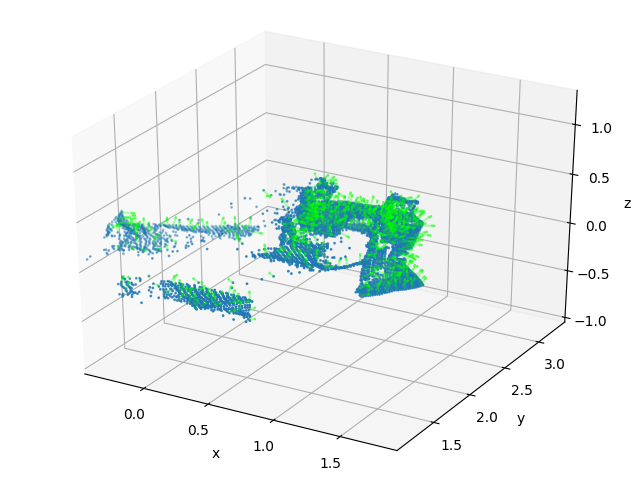

In [11]:
scene_pcn_crop = scene_pcn[260:670, 660:1150]

# pcn = scene_pcn
pcn = scene_pcn_crop
visualize_pcn(pcn)

In [12]:
scene_pcn.shape, scene_pcn_crop.shape

((1024, 1536, 6), (410, 490, 6))

In [13]:
model_mesh = pymesh.load_mesh(STL_PATH)
model_mesh = pymesh.form_mesh(model_mesh.vertices / 1000, model_mesh.faces)

In [14]:
def fix_mesh(mesh, detail="normal"):
    bbox_min, bbox_max = mesh.bbox;
    diag_len = np.linalg.norm(bbox_max - bbox_min);
    if detail == "normal":
        target_len = diag_len * 5e-3;
    elif detail == "high":
        target_len = diag_len * 2.5e-3;
    elif detail == "low":
        target_len = diag_len * 2e-2;
    target_len = 0.015
    print("Target resolution: {} mm".format(target_len));

    count = 0;
    mesh, __ = pymesh.remove_degenerated_triangles(mesh, 100);
    mesh, __ = pymesh.split_long_edges(mesh, target_len);
    num_vertices = mesh.num_vertices;
    while True:
        mesh, __ = pymesh.collapse_short_edges(mesh, 1e-6);
        mesh, __ = pymesh.collapse_short_edges(mesh, target_len,
                preserve_feature=True);
        mesh, __ = pymesh.remove_obtuse_triangles(mesh, 150.0, 100);
        if mesh.num_vertices == num_vertices:
            break;

        num_vertices = mesh.num_vertices;
        print("#v: {}".format(num_vertices));
        count += 1;
        if count > 10: break;

    mesh = pymesh.resolve_self_intersection(mesh);
    mesh, __ = pymesh.remove_duplicated_faces(mesh);
    mesh = pymesh.compute_outer_hull(mesh);
    mesh, __ = pymesh.remove_duplicated_faces(mesh);
    mesh, __ = pymesh.remove_obtuse_triangles(mesh, 179.0, 5);
    mesh, __ = pymesh.remove_isolated_vertices(mesh);

    return mesh;

model_mesh = fix_mesh(model_mesh)

Target resolution: 0.015 mm
#v: 2334
#v: 2238
#v: 2233


In [15]:
model_pc = model_mesh.vertices
model_mesh.add_attribute('vertex_normal')
model_norm = model_mesh.get_attribute('vertex_normal')
model_norm = np.reshape(model_norm, (-1, 3))
model_pcn = np.concatenate((model_pc, model_norm), axis=1)
model_pcn = np.ndarray.astype(model_pcn, np.float32)
model_pcn.shape

(2239, 6)

<IPython.core.display.Javascript object>


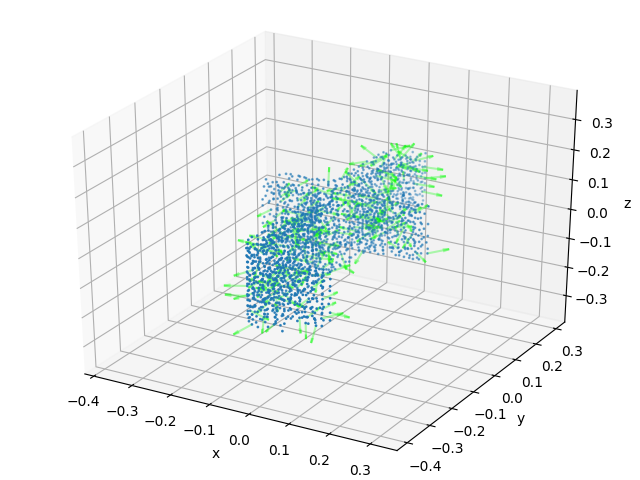

In [16]:
visualize_pcn(model_pcn, step1=1, step2=10, norm_len=0.05)

In [18]:
def pcn_to_mesh(pcn):
    points, normals = pcn[:, :, :3], pcn[:, :, 3:]
    height, width = points.shape[:2]
    faces = np.zeros((2 * (height - 1) * (width - 1), 3), dtype=np.int32)
    ind = 0
    calc_ind = lambda ih, iw: ih * width + iw
    for ih in range(1, height):
        for iw in range(1, width):
            faces[ind, :] = calc_ind(ih, iw), calc_ind(ih - 1, iw - 1), calc_ind(ih, iw - 1)
            ind += 1
            faces[ind, :] = calc_ind(ih, iw), calc_ind(ih - 1, iw), calc_ind(ih - 1, iw - 1)
            ind += 1
    vertices = points.reshape((-1, 3)).astype(np.float64)
    print(vertices.shape, vertices.dtype, faces.shape, faces.dtype)
    print('Generating mesh')
    mesh = pymesh.form_mesh(vertices, faces)
    mesh.add_attribute('vertex_normal')
    return mesh

scene_mesh = pcn_to_mesh(scene_pcn)
# fix_mesh(scene_mesh)

(1572864, 3) float64 (3140610, 3) int32
Generating mesh


In [19]:
# import pcl

def save_model_ply():
    print('Saving model.ply')
    pymesh.save_mesh('model.ply', model_mesh, 'vertex_normal')

def save_scene_ply():
    print('Saving scene.ply')
    pymesh.save_mesh('scene.ply', scene_mesh, 'vertex_normal')
    
    
def save_model_pcd():
    print('Saving model.pcd')
    pcl.PointCloud(model_pcn)
    print(pcl)

def save_scene_pcd():
    print('Saving scene.pcd')
    points, normals = scene_pcn[:, :, :3], scene_pcn[:, :, 3:]

print('model_mesh:', model_mesh.vertices.shape, model_mesh.vertices.dtype, model_mesh.faces.shape, model_mesh.faces.dtype)

# save_model_ply()
save_scene_ply()
# save_model_pcd()
# save_scene_pcd()


model_mesh: (2239, 3) float64 (4496, 3) int32
Saving scene.ply


In [117]:
# detector = cv2.ppf_match_3d_PPF3DDetector(0.03, 0.05)
detector = cv2.ppf_match_3d_PPF3DDetector(0.05, 0.05)
# detector.setSearchParams(0.2)
detector.trainModel(model_pcn)

AttributeError: 'cv2.ppf_match_3d_PPF3DDetector' object has no attribute 'setSearchParams'

In [107]:
# pcn = scene_pcn
pcn = scene_pcn_crop

pcn = np.reshape(pcn, (-1, 6))
# matches = detector.match(pcn, 1.0 / 5.0, 0.05)
matches_detected = detector.match(pcn, 1.0 , 0.15)

In [108]:
def filter_matches(matches, threshold=0.2):
    if not len(matches):
        return []
    res = [matches[0]]
    for i in range(1, len(matches)):
        m1, m2 = res[-1], matches[i]
        if np.linalg.norm(m1.pose[:, :3] - m2.pose[:, :3]) > threshold \
            and m2.t[2] > 0:
            res.append(m2)
    return res

matches_filtered = filter_matches(matches_detected)
print(f'Filtering matches: {len(matches_detected)} --> {len(matches_filtered)}')

Filtering matches: 97 --> 59


In [112]:
print(f'{len(matches_filtered)} matches')
for m in matches_filtered[:20]:
    if m.numVotes < 10:
        break
    print(m.t)
    print(m.numVotes, np.linalg.det(m.pose))

59 matches
(0.8440998406796527, 2.720495082711749, 0.15449224423559932)
31 0.020454861794012798
(0.02872447010712978, 2.023334670562215, 0.16791345179080963)
30 0.9999999999999996
(0.12329217816535193, 2.0831872102637004, 0.3221578443346195)
26 0.9999999999999999
(-0.0793847381542205, 2.2656204774312476, 0.06535689994121263)
22 1.0000000000000004
(0.8689699295791167, 1.7860068864640073, 0.19587241577159364)
21 0.9999999999999998
(0.9528265542021346, 2.4412150929048586, 0.5375522821817684)
20 0.8467417026085665
(0.5483837336374592, 2.08230875149298, 0.14560621743332947)
20 0.9999999999999997
(0.6761197046457931, 2.206069987890962, 0.43881819704528413)
19 1.0000000000000007
(0.7757603050161128, 2.671780866420692, 0.17229536365015655)
19 0.9999999999999992
(0.8177394841782617, 2.1662477486851612, 0.3801415115240886)
19 1.0000000000000002
(0.6460299208309688, 1.5159109192834503, 0.026819925762011254)
16 0.9999999999999996
(0.04004273920771784, 2.1169423001852525, 0.26707812652390617)
15 1.

<IPython.core.display.Javascript object>


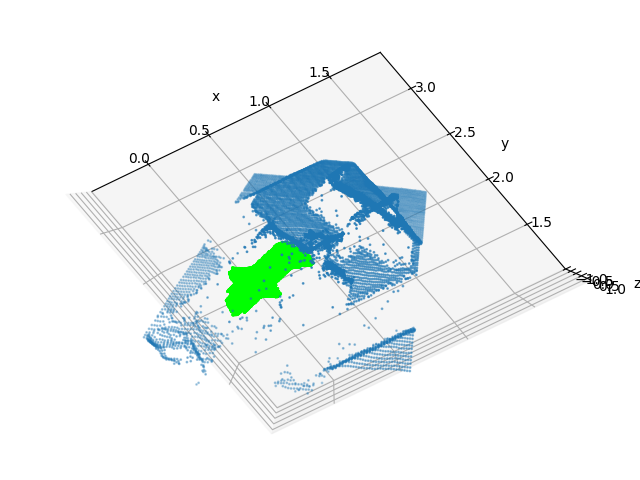

In [114]:
def visualize_mesh(ax, mesh, pose):
    vs, fs = mesh.vertices, mesh.faces
    vs = np.dot(np.hstack((vs, np.ones((len(vs), 1)))), pose.T)
    vs = vs[:, :3]
    triangles = [np.array([vs[fs[i][j]] for j in range(3)]) for i in range(len(fs))]
    triangles = np.array(triangles)
    col = art3d.Poly3DCollection(triangles)
    col.set_edgecolor((0, 1, 0))
    col.set_facecolor((0, 0, 0, 0))
    col.set_linewidth(2)
    ax.add_collection3d(col)

pcn = scene_pcn_crop
pose = matches_filtered[2].pose
# print(pose)
ax = visualize_pcn(pcn, show_normals=False)
visualize_mesh(ax, model_mesh, pose)


In [285]:
def rotation(theta):
    tx, ty, tz = theta
    Rx = np.array([[1, 0, 0], [0, np.cos(tx), -np.sin(tx)], [0, np.sin(tx), np.cos(tx)]])
    Ry = np.array([[np.cos(ty), 0, -np.sin(ty)], [0, 1, 0], [np.sin(ty), 0, np.cos(ty)]])
    Rz = np.array([[np.cos(tz), -np.sin(tz), 0], [np.sin(tz), np.cos(tz), 0], [0, 0, 1]])
    return np.dot(Rx, np.dot(Ry, Rz))

max_rad = np.pi / 90
R = rotation([
    np.random.uniform(-max_rad, max_rad),
    np.random.uniform(-max_rad, max_rad),
    np.random.uniform(-max_rad, max_rad)
])
print('R det', np.linalg.det(R))
t = np.random.rand(3, 1)
pts = np.dot(model_pcn[:, :3], R.T) + t.T
norms = np.dot(model_pcn[:, 3:], R.T)
rand_pcn = np.hstack((pts, norms))
rand_pcn = np.ndarray.astype(rand_pcn, np.float32)
matches = detector.match(rand_pcn, 1.0, 0.05)
print('GT:', R, t)

3

In [244]:
# icp = cv2.ppf_match_3d_ICP(200, 0.001, 2.5, 8);
icp = cv2.ppf_match_3d_ICP(1200);

retval, residual, pose = icp.registerModelToScene(model_pcn, scene_pcn)
print(pose)

[[ 0.83680581  0.48671541  0.25072725  1.00760143]
 [-0.52553124  0.84247524  0.11854279  0.40234706]
 [-0.15353489 -0.23096229  0.96077232  0.35588668]
 [ 0.          0.          0.          1.        ]]


In [176]:
nyu_path = '/home/burakov/prog/depth/bts/result_bts_nyu/'
fname_base = 'bathroom_rgb_00708'
fname_base = 'bedroom_rgb_00969'
image_path = os.path.join(nyu_path, 'rgb', f'{fname_base}.jpg')
depth_path = os.path.join(nyu_path, 'raw', f'{fname_base}.png')
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
depth = cv2.imread(depth_path, -1)
depth = depth.astype(np.float32) / 1000
print(img.shape, img.min(), img.max())
print(depth.shape, depth.min(), depth.max())

(480, 640, 3) 0 255
(480, 640) 1.981 4.836


<IPython.core.display.Javascript object>


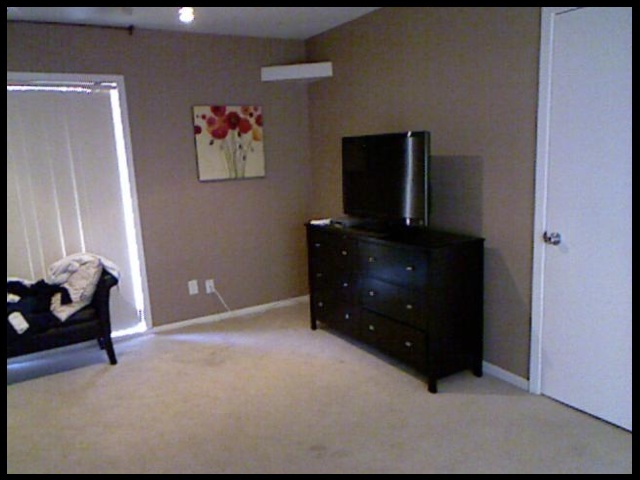

In [177]:
fig = plt.figure()
fig.subplots_adjust(left=0, top=1, right=1, bottom=0)
fig.add_subplot(111)
plt.imshow(img)

<IPython.core.display.Javascript object>


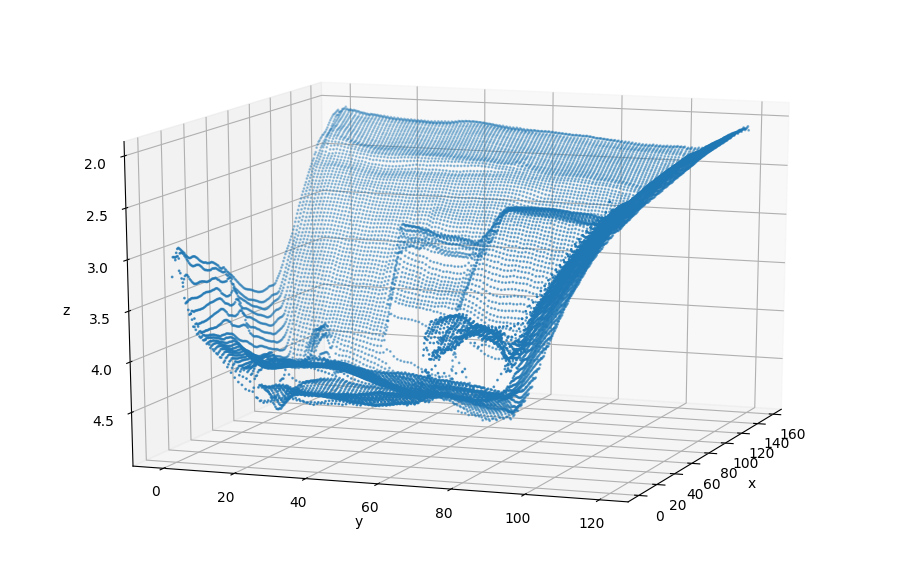

In [178]:
fig = plt.figure()
fig.subplots_adjust(left=0, top=1, right=1, bottom=0)
ax = fig.add_subplot(111, projection='3d')

dp = depth[::4, ::4]
h, w = dp.shape
y, x = np.array(range(h), np.float32), np.array(range(w), np.float32)
pc = np.ones((h, w, 3), np.float32)
pc[:, :, 0] = np.repeat(x[np.newaxis, :], h, axis=0)
pc[:, :, 1] = np.repeat(y[:, np.newaxis], w, axis=1)
pc[:, :, 2] = dp

pc1 = np.reshape(pc, (-1, 3))
ax.scatter(pc1[:, 0], pc1[:, 1], pc1[:, 2], s=1)

ax.set_xlabel('x'), ax.set_ylabel('y'), ax.set_zlabel('z')
ax.view_init(elev=-90, azim=0)

In [190]:
a = np.random.rand(2, 3, 2)
b = np.array([2, -2])
print(a, b)

[[[0.86125803 0.20212598]
  [0.22678311 0.62222599]
  [0.71997362 0.53507008]]

 [[0.80742887 0.92492727]
  [0.33845759 0.70427136]
  [0.30388464 0.11919725]]] [ 2 -2]


In [191]:
a + b

array([[[ 2.86125803, -1.79787402],
        [ 2.22678311, -1.37777401],
        [ 2.71997362, -1.46492992]],

       [[ 2.80742887, -1.07507273],
        [ 2.33845759, -1.29572864],
        [ 2.30388464, -1.88080275]]])

In [194]:
A = np.array([[1, -1], [1, -1]])
print(A)
print(np.dot(a, A))

[[ 1 -1]
 [ 1 -1]]
[[[ 1.063384   -1.063384  ]
  [ 0.8490091  -0.8490091 ]
  [ 1.25504369 -1.25504369]]

 [[ 1.73235615 -1.73235615]
  [ 1.04272895 -1.04272895]
  [ 0.42308189 -0.42308189]]]


In [124]:
width = 20
height = 10
max_deg = np.pi / 12

cloud, rotated_cloud = [None]*3, [None]*3
retval, residual, pose = [None]*3, [None]*3, [None]*3
noise = np.random.normal(0.0, 0.1, height * width * 3).reshape((-1, 3))
noise2 = np.random.normal(0.0, 1.0, height * width)

x, y = np.meshgrid(
    range(-width//2, width//2),
    range(-height//2, height//2),
    sparse=False, indexing='xy'
)
z = np.zeros((height, width))

cloud[0] = np.dstack((x, y, z)).reshape((-1, 3)).astype(np.float32)
cloud[1] = noise.astype(np.float32) + cloud[0]
cloud[2] = cloud[1]
cloud[2][:, 2] += noise2.astype(np.float32)

R = rotation([
    np.random.uniform(-max_deg, max_deg),
    np.random.uniform(-max_deg, max_deg),
    np.random.uniform(-max_deg, max_deg)
])
# t = np.zeros((3, 1))
t = np.random.rand(3, 1)
Rt = np.vstack((
    np.hstack((R, t)),
    np.array([0, 0, 0, 1])
)).astype(np.float32)

In [125]:
# icp = cv2.ppf_match_3d_ICP(100)
icp = cv2.ppf_match_3d_ICP(200, 0.001, 2.5, 8);

I = np.eye(4)
print("Unaligned error:\t%.6f" % np.linalg.norm(I - Rt))
for i in range(3):
    rotated_cloud[i] = np.matmul(Rt[0:3,0:3], cloud[i].T).T + Rt[:3,3].T
    retval[i], residual[i], pose[i] = icp.registerModelToScene(rotated_cloud[i], cloud[i])
    print("ICP error:\t\t%.6f" % np.linalg.norm(I - np.matmul(pose[i], Rt)))
    print(residual[i])

Unaligned error:	1.457873
ICP error:		0.018327
0.0008323310255206233
ICP error:		0.000000
5.413083301787549e-09
ICP error:		0.000000
5.537783415084066e-09


In [123]:
np.random.rand(3, 1)

array([[0.28371446],
       [0.37894921],
       [0.72849567]])

In [286]:
mm = Mesh.from_file(STL_PATH)
mm.vectors.shape
# model_mesh.vectors /= 1000 # TODO: Find more official way
# model_pcn = dsu.get_pcn_from_mesh(model_mesh)
# model_pc = model_pcn[:, :3]

(92114, 3, 3)

In [296]:
a =  np.array([[0.9683065, 0.01364894, -0.0349186],
 [-0.01402131,  0.96887792, -0.01010272],
 [ 0.03477074 , 0.01060041,  0.96834999]])
np.linalg.det(a)

0.9099434448692043